## Etape 1 : Scraping des résultats depuis bases.athle

Objectifs :
+ créer un pipeline pour récupérer les données d'une compétition d'athlétisme (course sur route, trail, cross, ...)
+ retourner ces données sous la forme d'une table relationnelle
+ par la suite, exploiter cette table pour créer des statistiques et visualisations sur les compétitions

Format d'une URL de bases.athle :
+ ? avant la requête
+ & pour ajouter des paramètres à la recherche 

bases.athle.fr/asp.net/liste.aspx**?frmbase=resultats**&**frmmode=1**&**frmespace=0**&**frmcompetition=**274211

Liste des paramètres pour une recherche par athlète :
+ frmsaison
+ frmclub
+ frmnom
+ frmprenom
+ frmsexe
+ frmlicence
+ frmdepartement
+ frmligue
+ frmcomprch


### Installation de la libraire lxml

In [1]:
!pip install lxml

### Import des librairies requises

In [2]:
import lxml
import urllib
import bs4
import pandas as pd
import re
from urllib import request

In [69]:
#Exemple de résultats d'une compétition
url="https://bases.athle.fr/asp.net/liste.aspx?frmbase=resultats&frmmode=1&frmespace=0&frmcompetition=253657"

In [4]:
request_text = request.urlopen(url).read()

In [5]:
page = bs4.BeautifulSoup(request_text, "lxml")

### Dictionnaires utiles

#### Catégories de performance et cotation d'après table FFA

In [6]:
#bareme et table de cotation
#source: https://www.athle.fr/asp.net/main.html/html.aspx?htmlid=125

perf = {'IA': 40, 'IB': 35, #international
        'N1': 30, 'N2': 28, 'N3': 26, 'N4': 24, #national
        'IR1': 21, 'IR2': 20, 'IR3': 19, 'IR4': 18, #inter-regional
        'R1': 15, 'R2': 14, 'R3': 13, 'R4': 12, 'R5': 11, 'R6': 10, #regional
        'D1': 8, 'D2': 7, 'D3': 6, 'D4': 5, 'D5': 4, 'D6': 3, 'D7': 2} #departemental

#### Catégories d'âge d'après la réglementation FFA

In [7]:
#categories d'âge en 2023
#source: https://www.athle.fr/asp.net/main.html/html.aspx?htmlid=25

cat = {'M10': 'Masters 10', 'M9': 'Masters 9', 'M8': 'Masters 8', 'M7': 'Masters 7', 'M6': 'Masters 6',
       'M5': 'Masters 5', 'M4': 'Masters 4', 'M3': 'Masters 3', 'M2': 'Masters 2', 'M1': 'Masters 1', 'M0': 'Masters 0',
       'SE': 'Seniors',
       'ES': 'Espoirs',
       'JU': 'Juniors',
       'CA': 'Cadet.te.s',
       'MI': 'Minimes',
       'BE': 'Benjamin.e.s',
       'PO': 'Poussins',
       'EA': 'École d\'Athlétisme',
       'BB': 'Baby Athlé'}

In [44]:
categoriesF=list(cat.keys())

#ajout des catégories féminines
for i in range(len(categoriesF)):
    categoriesF[i]+='F'
categoriesM=list(cat.keys())

#ajout des catégories masculines
for i in range(len(categoriesM)):
    categoriesM[i]+='M'
    
categories=categoriesF+categoriesM

## Date, nom, lieu, ligue, label et département de la compétition

In [8]:
header = page.find('div', {'class' : "mainheaders"})
header=str(header)
print(header)

<div class="mainheaders">06/11/22 - 10 km de Riorges<br/><span style="font-size:13px">Riorges - ARA - 042 - Label Régional</span></div>


#### Nom de la compétition

In [9]:
re_nom = re.compile("(?<=\- )(.*?)(?=\<)")
text = re_nom.findall(header)
nom = text[0]
sous_titre = text[1]
print(nom)

10 km de Riorges


#### Lieu de la compétition

In [10]:
re_lieu = re.compile("(?<=\>)(\D*?)(?=\ -)")
lieu = re_lieu.findall(header)[0]
print(lieu)

Riorges


#### Date de la compétition

In [11]:
re_date = re.compile("[0-9]{2}/[0-9]{2}/[0-9]{2}")
date = re_date.findall(header)[0]
print(date)

06/11/22


#### Ligue de la compétition

In [12]:
soustitre = nom[1]
re_ligue = re.compile("[A-Z]{3}")
ligue = re_ligue.findall(sous_titre)[0]
print(ligue)

ARA


#### Département de la compétition

In [13]:
re_dept = re.compile("[0-9]{3}")
dept = re_dept.findall(sous_titre)[0]
print(dept)

042


#### Label de la compétition (en cours)

In [14]:
re_label = re.compile("(?<=Label ).*(?<!')")
try:
    label = re_label.findall(sous_titre)[0]
    print(label)
except IndexError:
    print("Pas de label pour cette compétition")

Régional


#### Données de la compétition sous forme de dictionnaire

In [15]:
compet= {'nom': nom,
      'lieu': lieu,
      'date': date,
      'ligue': ligue,
      'dept': dept,
      'label': label}

In [16]:
compet['dept']

'042'

In [17]:
print(page.find("title"))

<title>les Résultats des Compétitions</title>


In [18]:
print(page.find("mainheaders"))

None


In [19]:
print("Il y a", len(page.findAll("tr")), "éléments dans la page qui sont des <tr>")

Il y a 257 éléments dans la page qui sont des <tr>


In [20]:
print(page.find('a', {'title' : 'Records principaux pour cette épreuve'}))

<a class="white" href="/asp.net/liste.aspx?frmbase=records&amp;frmmode=2&amp;frmespace=0&amp;frmcompetition=253657&amp;frmepreuve=261&amp;frmsexe=M&amp;frmserie=10 Km Route TC" title="Records principaux pour cette épreuve">10 Km Route TC</a>


## Athlètes et chronos de la compétition

In [21]:
text = str(page.findAll('td', {'class' : 'datas1'}))
text = text.replace("<td class=\"datas1\">", "")
text = text.replace("</b>", "")
text = text.replace("<b>", "")
text = text.replace("<td>", "")
text = text.replace("</td>", "")

In [22]:
page.findAll('td', {'class' : 'datas1'})[6]

<td class="datas1"><a href="/asp.net/liste.aspx?frmbase=resultats&amp;frmmode=1&amp;frmespace=0&amp;frmcompetition=253657&amp;frmepreuve=10 Km Route TC&amp;frmcategorie=SE&amp;frmsexe=M" title="Résultats pour la catégorie du participant">SEM</a>/89</td>

In [23]:
headers = []
for i in page.find_all('td'):
    title = i.text
    headers.append(title)

In [24]:
L=[]
for i in page.find_all('tr'):
    L.append(i)

### Athlètes

In [25]:
re_athlete = re.compile("[A-Z]{2,} [A-Z]*[A-Z]*[A-Z]{1}[a-z]*")

In [26]:
athletes=[]
for i in L:
    athletes.append(re_athlete.findall(str(i)))
athletes=[x for x in athletes if x!=[]]
athletes[:10]

[['LORTON Guillaume'],
 ['BETRON Adrien'],
 ['MOULIN Loic'],
 ['DEBROUCKER Guillaume'],
 ['KEMEI Charles'],
 ['SPIMOLA MARQUES'],
 ['CROUZET Corentin'],
 ['BURNICHON Antoine'],
 ['BUISSON Antoine'],
 ['CROUE Jeremy']]

### Chronos de la compétition

In [27]:
re_temps = re.compile("<b>(?=\d).*(?=<\/b>)")

In [28]:
temps=[]
for i in L:
    temps.append(re_temps.findall(str(i)))
temps=[x for x in temps if x!=[]]
for i in range(len(temps)):
    temps[i]=temps[i][0].replace("<b>","")
    temps[i]=pd.to_datetime(temps[i], format='%Hh%M\'%S\'\'', errors='ignore')
    temps[i]=pd.to_datetime(temps[i], format='%M\'%S\'\'', errors='ignore')
    temps[i]=pd.to_datetime(temps[i], format='%S\'\'', errors='ignore')
temps[:10]

[Timestamp('1900-01-01 00:30:58'),
 Timestamp('1900-01-01 00:31:30'),
 Timestamp('1900-01-01 00:32:01'),
 Timestamp('1900-01-01 00:32:15'),
 Timestamp('1900-01-01 00:32:40'),
 Timestamp('1900-01-01 00:33:02'),
 Timestamp('1900-01-01 00:33:38'),
 Timestamp('1900-01-01 00:33:41'),
 Timestamp('1900-01-01 00:34:54'),
 Timestamp('1900-01-01 00:35:16')]

### Ligue des athlètes

In [30]:
re_ligue = re.compile("[A-Z]{3,}(?=<)")

In [31]:
ligue=[]
for i in L:
    match = re_ligue.search(str(i))
    if (match==None) or (match.group() in categories):
        ligue.append('0')
    else:
        ligue.append(match.group())
ligue[:10]

['0', '0', '0', '0', '0', '0', 'ARA', 'ARA', 'ARA', 'ARA']

### Cotations des performances

In [33]:
re_perf = re.compile("[A-Z]{1,}[1-8](?=<)")

In [34]:
perfs=[]
for i in L:
    perfs.append(str(re_perf.findall(str(i))).replace('[','').replace(']','').replace('\'',''))
perfs[:10]

['', '', '', '', '', '', 'N4', 'IR1', 'IR2', 'IR2']

### Catégories des athlètes

In [124]:
re_cat = re.compile("[A-Z]{3}(?=<)|[A-Z]{1}\d[A-Z]{1}")

In [141]:
categorie=[]
for i in L:
    match = re_cat.search(str(i))
    if (match==None):
        categorie.append('0')
    else:
        match = re_cat.findall(str(i))
        if len(match)>1 and (match[1] in categories):
            categorie.append(match[1])
        else:
            if (match[0] in categories):
                categorie.append(match[0])
categorie[:10]

['0', '0', '0', '0', '0', '0', 'SEM', 'SEM', 'SEM', 'M1M']

### Années de naissance

In [72]:
re_annee = re.compile("\/[0-9]{2}<")

In [94]:
annee=[]
for i in L:
    match = re_annee.search(str(i))
    if (match==None) or (match.group() in categories):
        annee.append('0')
    else:
        year = int(str(match.group()).replace('/','').replace('<',''))
        if year <=20:
            annee.append(year+2000)
        else:
            annee.append(year+1900)

In [96]:
annee[:10]

['0', '0', '0', '0', '0', '0', 1989, 1989, 1992, 1982]

### Clubs des athlètes (en cours)

In [35]:
re_club = re.compile("[A-Z][a-z]+ *-*[A-Z][a-z]+ *-*[A-Z]*[a-z] *-*[A-Z]*[a-z]*(?=<)")

In [36]:
clubs=[]
for i in L:
    clubs.append(re_club.findall(str(i)))
clubs[:10]

[[],
 [],
 [],
 [],
 [],
 ['Km Route TC'],
 ['Montlucon Athletisme'],
 ['Beaujolais Runners'],
 ['Lyon Athletisme'],
 []]

In [131]:
liste=[]
debut=len(ligue)-len(athletes)-1
for i in range(len(athletes)):
    ligne=[]
    ligne.append(athletes[i][0])
    ligne.append(ligue[i+debut])
    ligne.append(str(clubs[i+debut]))
    ligne.append(temps[i])
    ligne.append(perfs[i+debut])
    ligne.append(annee[i+debut])
    ligne.append(categorie[i+debut])
    liste.append(ligne)

In [132]:
len(athletes), len(perfs), len(ligue), len(clubs), len(annee), len(categorie)

(250, 257, 257, 257, 257, 257)

In [133]:
data=pd.DataFrame(liste, columns=["Athlète", "Ligue", "Club", "Chrono", "Performance", "Naissance", "Catégorie"])

In [134]:
#data['hours']=data['Chrono'].dt.hour
#data['minutes']=data['Chrono'].dt.minute
#data['seconds']=data['Chrono'].dt.second

data['time_delta']=data['Chrono']-pd.to_datetime("'1900-01-01")
data['time_gap']=data["Chrono"]-data['Chrono'][0]
data['duration']=data['time_delta'].dt.total_seconds()
data['Nom']=data['Athlète'].str.split(n = 0, expand = False).str[0]
data['Prénom']=data['Athlète'].str.split(n = 0, expand = False).str[1]

data=data.drop("Chrono", axis=1)
data.head()

,Athlète,Ligue,Club,Performance,Naissance,Catégorie,time_delta,time_gap,duration,Nom,Prénom
0,LORTON Guillaume,ARA,['Montlucon Athletisme'],N4,1989,SEM,0 days 00:30:58,0 days 00:00:00,1858.0,LORTON,Guillaume
1,BETRON Adrien,ARA,['Beaujolais Runners'],IR1,1989,SEM,0 days 00:31:30,0 days 00:00:32,1890.0,BETRON,Adrien
2,MOULIN Loic,ARA,['Lyon Athletisme'],IR2,1992,SEM,0 days 00:32:01,0 days 00:01:03,1921.0,MOULIN,Loic
3,DEBROUCKER Guillaume,ARA,[],IR2,1982,M1M,0 days 00:32:15,0 days 00:01:17,1935.0,DEBROUCKER,Guillaume
4,KEMEI Charles,ARA,['Club Athletique Roannais'],IR2,1984,M0M,0 days 00:32:40,0 days 00:01:42,1960.0,KEMEI,Charles


### Premier exemple de visualisation : distribution des chronos

<AxesSubplot: ylabel='Density'>

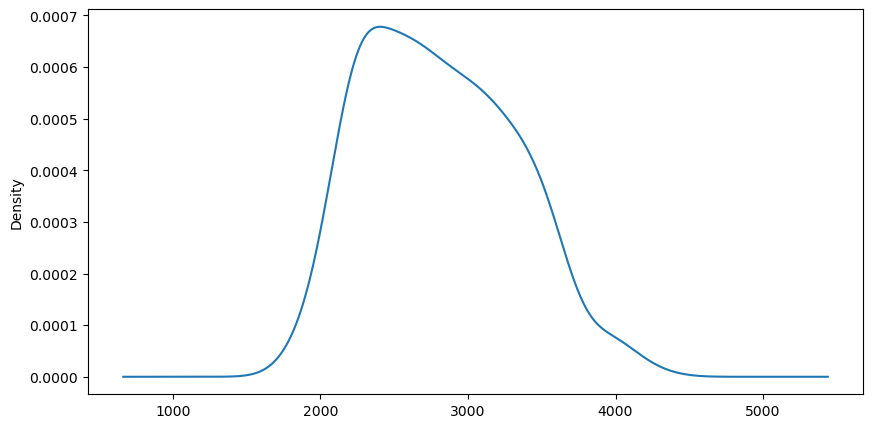

In [140]:
data["duration"].plot(kind='kde', figsize=(10,5))

### Deuxième exemple de visualisation : écart avec le premier

<AxesSubplot: >

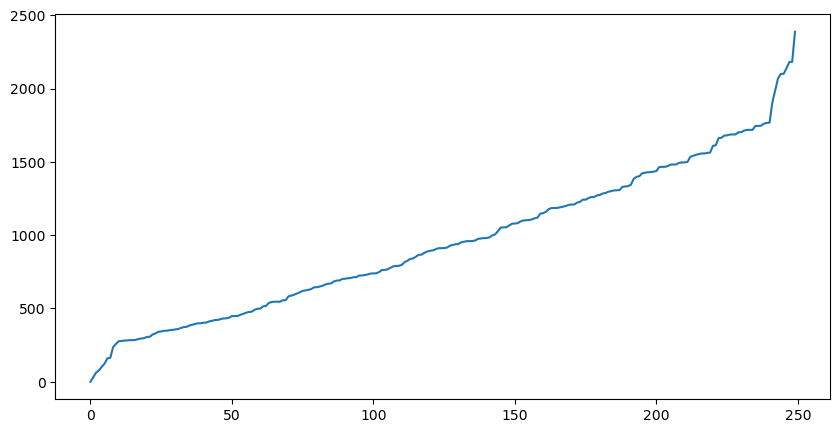

In [139]:
data["time_gap"].dt.total_seconds().plot(figsize=(10,5))

### Troisième exemple de visualisation : histogramme des performances (labels FFA)

<AxesSubplot: >

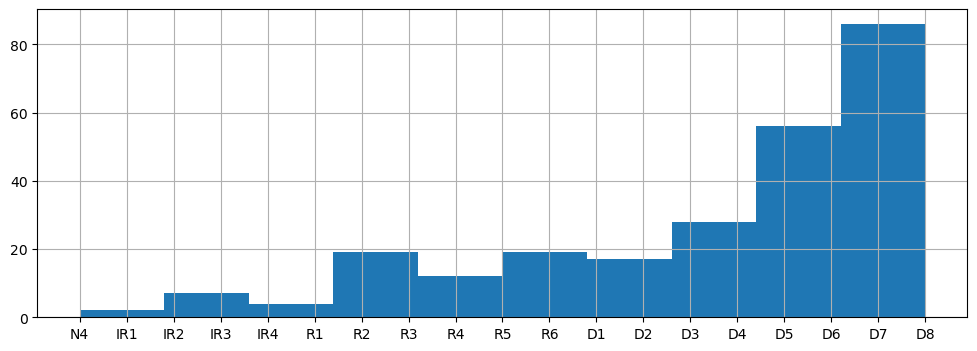

In [138]:
data["Performance"].hist(figsize=(12,4))

<AxesSubplot: >

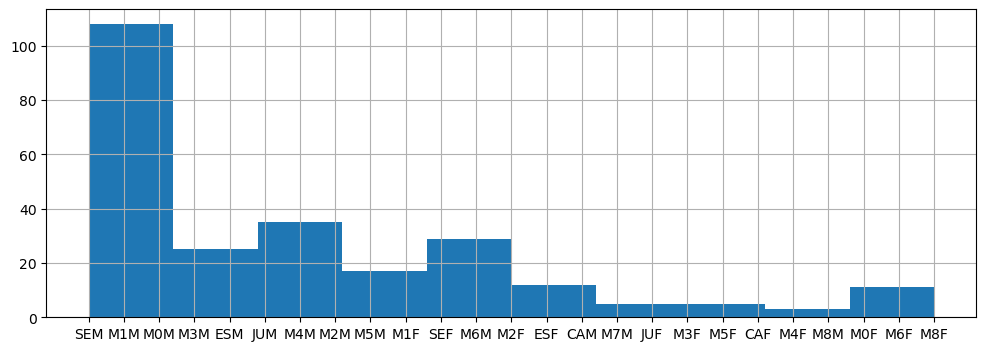

In [137]:
data["Catégorie"].hist(figsize=(12,4))